In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img


from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Saving Pictures settings

In [2]:
picture_size = 48
folder_path = "data/"

## Storing Data into variables

In [3]:
batch_size = 128

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                             target_size = (picture_size, picture_size),
                                             color_mode = "grayscale",
                                             batch_size = batch_size,
                                             class_mode = "categorical",
                                             shuffle = True)

test_set = datagen_test.flow_from_directory(folder_path+"validation",
                                             target_size = (picture_size, picture_size),
                                             color_mode = "grayscale",
                                             batch_size = batch_size,
                                             class_mode = "categorical",
                                             shuffle = True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Creating Model

In [4]:
nr_of_classes = 7
#Model Structure
model = Sequential()

model.add(Input(shape=(picture_size,picture_size,1)))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
          
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

    
model.add(Dense(nr_of_classes, activation="softmax"))

#Compile
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

## Model Training

In [5]:
early_stopping = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )
epochs = 60

In [6]:
status = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=epochs,
    validation_data = test_set,
    validation_steps = len(test_set),
    callbacks=early_stopping
)

Epoch 1/60
226/226 [==============================] - 18s 58ms/step - loss: 2.6408 - accuracy: 0.2319 - val_loss: 2.0079 - val_accuracy: 0.2086
Epoch 2/60
226/226 [==============================] - 12s 54ms/step - loss: 2.2299 - accuracy: 0.3070 - val_loss: 1.8932 - val_accuracy: 0.2785
Epoch 3/60
226/226 [==============================] - 12s 55ms/step - loss: 2.0217 - accuracy: 0.3415 - val_loss: 1.5916 - val_accuracy: 0.4106
Epoch 4/60
226/226 [==============================] - 12s 53ms/step - loss: 1.8769 - accuracy: 0.3757 - val_loss: 1.4713 - val_accuracy: 0.4512
Epoch 5/60
226/226 [==============================] - 12s 53ms/step - loss: 1.7546 - accuracy: 0.4034 - val_loss: 1.3985 - val_accuracy: 0.4839
Epoch 6/60
226/226 [==============================] - 12s 53ms/step - loss: 1.6676 - accuracy: 0.4254 - val_loss: 1.3518 - val_accuracy: 0.4914
Epoch 7/60
226/226 [==============================] - 13s 56ms/step - loss: 1.5920 - accuracy: 0.4453 - val_loss: 1.3223 - val_accuracy:

In [7]:
model.save("models/facial_emotion_model.h5")

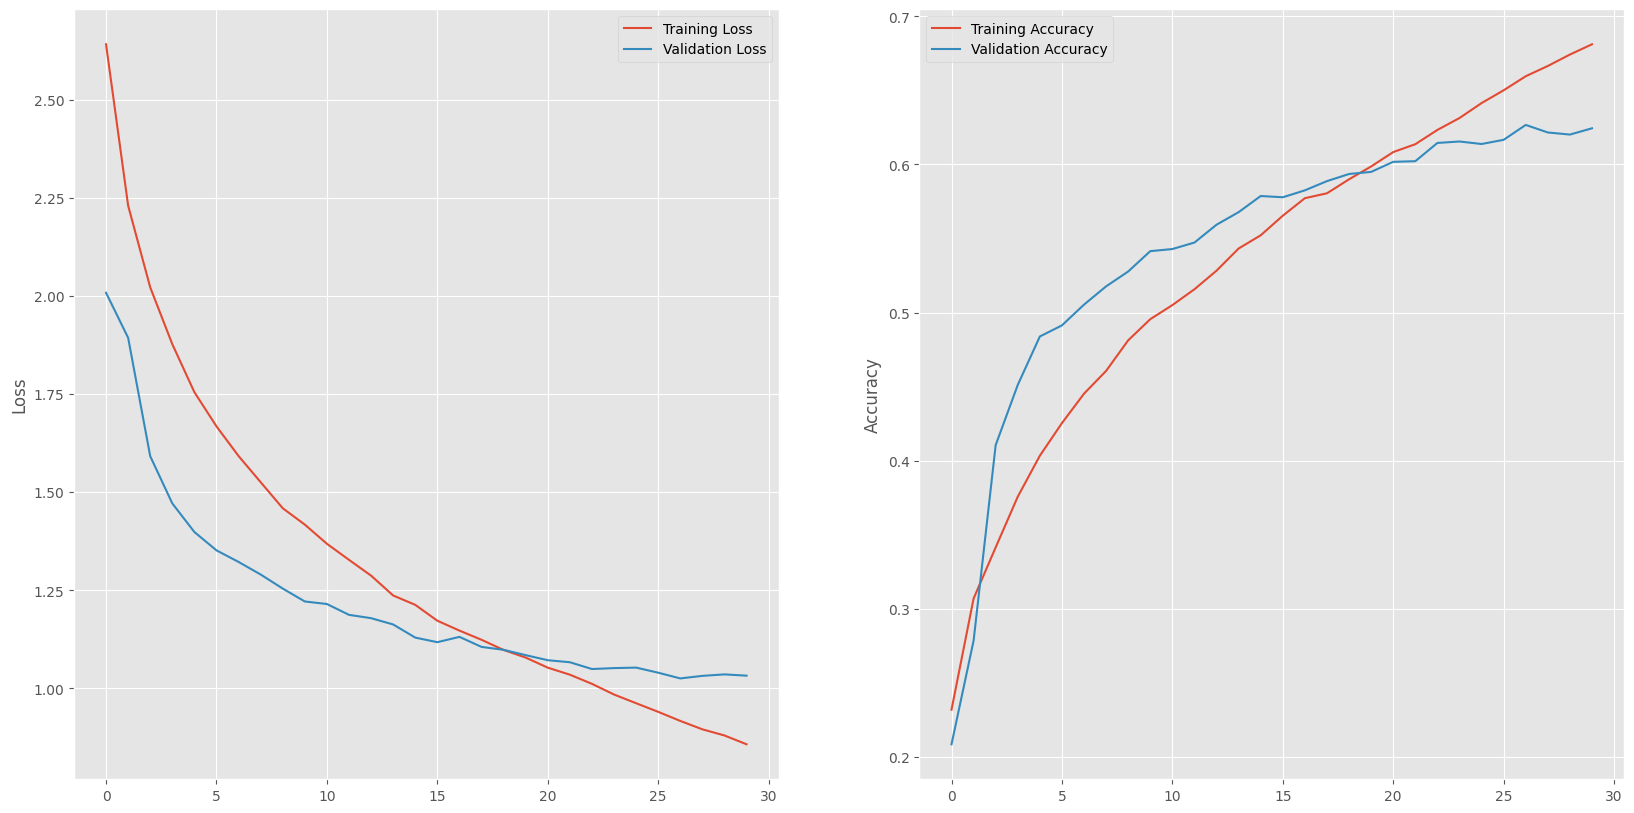

In [8]:
plt.style.use('ggplot')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.plot(status.history['loss'], label='Training Loss')
plt.plot(status.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.plot(status.history['accuracy'], label='Training Accuracy')
plt.plot(status.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

## Testing

In [9]:
def predictAndDraw(img_path):
    img = Image.open(img_path).convert('L') 
    img = img.resize((48, 48))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    print()
    img_array = img_array / 255.0  
    
    predictions = model.predict(img_array)

    predicted_class = np.argmax(predictions, axis=1)
    
    class_labels = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprise",}  # Example class labels
    predicted_label = class_labels[predicted_class[0]]
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 380ms/step


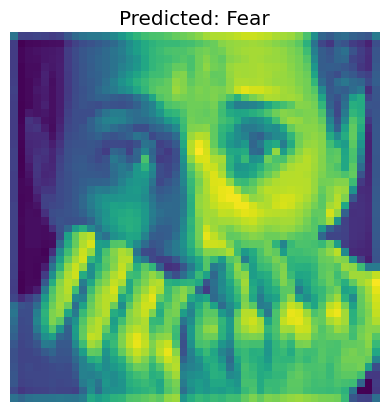


1/1 [==============================] - 0s 23ms/step


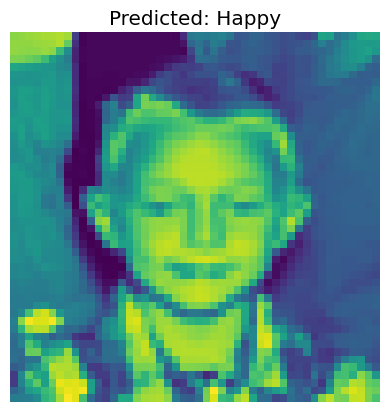


1/1 [==============================] - 0s 21ms/step


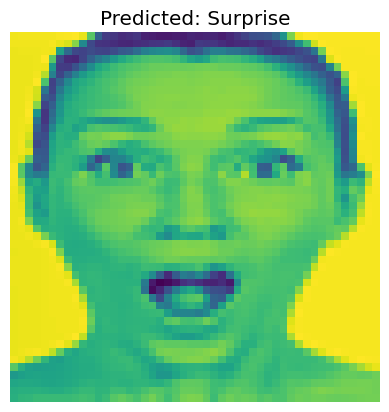


1/1 [==============================] - 0s 34ms/step


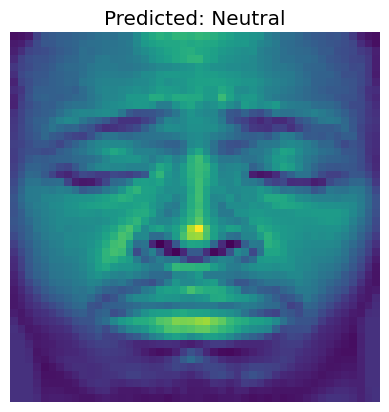


1/1 [==============================] - 0s 36ms/step


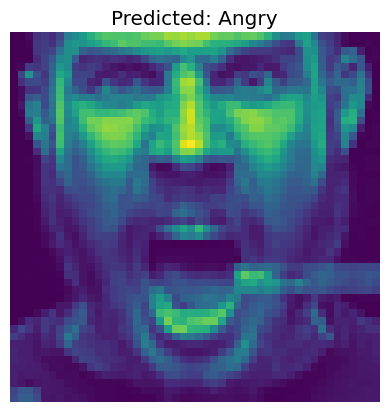


1/1 [==============================] - 0s 56ms/step


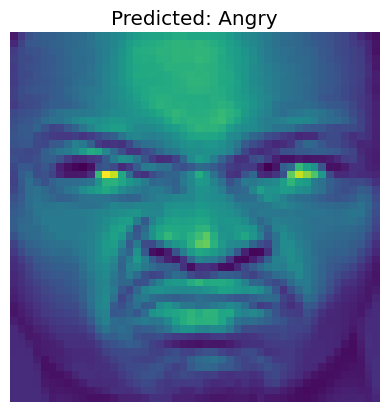

In [10]:
predictAndDraw("ExtraTest/feared.jpg")
predictAndDraw("ExtraTest/happykid.png")
predictAndDraw("ExtraTest/surprised.jpg")
predictAndDraw("ExtraTest/sadboy.jpg")
predictAndDraw("ExtraTest/angryboy.jpg")
predictAndDraw("ExtraTest/disgustedboy.jpg")